Read the readme.md file first.
EDA:

In [2]:
import pandas as pd
import numpy as np
#plotting and statistical packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
#display graphs in notebook
%matplotlib inline
#displays a load bar for tracking loop time processing
from tqdm import tqdm


In [3]:
#lets load the first chunk of data and look around
instacart_file=pd.read_csv('Data/orders.csv')
df_orders=pd.DataFrame(instacart_file,)
df_orders.head(12)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


# Draft data set up below

In [4]:
#df_orders.pivot(index='user_id',columns='order_id',values='eval_set')

# EDA follows

In [5]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
order_id                  int64
user_id                   int64
eval_set                  object
order_number              int64
order_dow                 int64
order_hour_of_day         int64
days_since_prior_order    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


The eval_set has broken data down to a prior data set, a training set and a test set. (see data readme.md for more details data (column meaings, NaN useage, and data useage terms and conditions).

Lets segregate our data in order to keep the test data fresh and uncontaminated. We'll explore around in the prior data set to get an idea about the data. Then look at setting up the mechanics for the recommendor.

In [6]:
df_prior_set=df_orders[df_orders['eval_set']=='prior']
df_prior_set.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [7]:
df_train_set=df_orders[df_orders['eval_set']=='train']
df_train_set.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
10,1187899,1,train,11,4,8,14.0
25,1492625,2,train,15,1,11,30.0
49,2196797,5,train,5,0,11,6.0
74,525192,7,train,21,2,11,6.0
78,880375,8,train,4,1,14,10.0


In [8]:
df_test_set=df_orders[df_orders['eval_set']=='test']
df_test_set.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
53,1528013,6,test,4,3,16,22.0
96,1376945,11,test,8,6,11,8.0
102,1356845,12,test,6,1,20,30.0


In [9]:
df_prior_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214874 entries, 0 to 3421081
Data columns (total 7 columns):
order_id                  int64
user_id                   int64
eval_set                  object
order_number              int64
order_dow                 int64
order_hour_of_day         int64
days_since_prior_order    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 196.2+ MB


In [10]:
df_prior_set.describe()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3.214874e+06,3.214874e+06,3.214874e+06,3.214874e+06,3.214874e+06,3.008665e+06
mean,1.710827e+06,1.029701e+05,1.719107e+01,2.776364e+00,1.344347e+01,1.070724e+01
std,9.875206e+05,5.953411e+04,1.779950e+01,2.041806e+00,4.226246e+00,8.954180e+00
min,2.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.556832e+05,5.138500e+04,5.000000e+00,1.000000e+00,1.000000e+01,4.000000e+00
50%,1.711120e+06,1.026620e+05,1.100000e+01,3.000000e+00,1.300000e+01,7.000000e+00
75%,2.566034e+06,1.543720e+05,2.400000e+01,5.000000e+00,1.600000e+01,1.500000e+01
max,3.421083e+06,2.062090e+05,9.900000e+01,6.000000e+00,2.300000e+01,3.000000e+01


In [11]:
df_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131209 entries, 10 to 3421082
Data columns (total 7 columns):
order_id                  131209 non-null int64
user_id                   131209 non-null int64
eval_set                  131209 non-null object
order_number              131209 non-null int64
order_dow                 131209 non-null int64
order_hour_of_day         131209 non-null int64
days_since_prior_order    131209 non-null float64
dtypes: float64(1), int64(5), object(1)
memory usage: 8.0+ MB


In [12]:
df_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75000 entries, 38 to 3421068
Data columns (total 7 columns):
order_id                  75000 non-null int64
user_id                   75000 non-null int64
eval_set                  75000 non-null object
order_number              75000 non-null int64
order_dow                 75000 non-null int64
order_hour_of_day         75000 non-null int64
days_since_prior_order    75000 non-null float64
dtypes: float64(1), int64(5), object(1)
memory usage: 4.6+ MB


In [13]:
# non-null is limited to the days_since_prior_order
for col in df_prior_set.columns:
    print(df_prior_set[col].isnull().any())

False
False
False
False
False
False
True


Lets look at how users order. First by seeing how many orders each user has in the data set.

In [14]:
#group prior data by user_id
dfp_gp_user=df_prior_set.groupby('user_id')

In [15]:
#create pandas series for number of orders by user and plot
user_order_count=dfp_gp_user.order_number.max()
user_order_count.head()

user_id
1    10
2    14
3    12
4     5
5     4
Name: order_number, dtype: int64

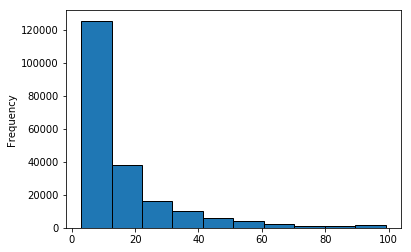

In [16]:
user_order_count.plot(kind='hist',edgecolor='black')

Looking at order counts by users we wee that most users order between 1 and 20 orders.

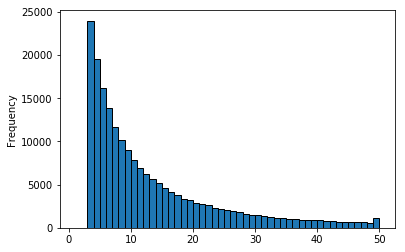

In [17]:
# a closer look at orders between 0 to 50
user_order_count.plot(kind='hist',bins=np.linspace(1,50),edgecolor='black')

In [18]:
user_order_count.median()

9.0

In [19]:
user_order_count.describe()

count    206209.000000
mean         15.590367
std          16.654774
min           3.000000
25%           5.000000
50%           9.000000
75%          19.000000
max          99.000000
Name: order_number, dtype: float64

206 thousand orders. A range for users orders between 3 and 99 orders. An mean of 16 orders per user and a median of 9 orders. 

Lets look at Orders by Day of the Week. What day are people shopping?

Text(0.5,0,u'Orders by Day of the Week')

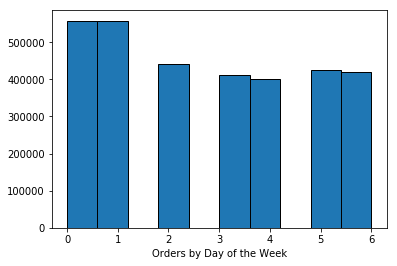

In [20]:
plt.hist(df_prior_set.order_dow, edgecolor='black')
plt.xlabel("Orders by Day of the Week")


The data set is not clear on which day zero is. The beginning of Instacart week does see the most 
orders with he rest of the week being closely similiar. (It would be a logical assumption that 0 
and 1 represent the weekend, however, we do not know this.)


Lets look at hour of the day. When are most orders received?

Text(0.5,0,u'Orders by Hour of Day')

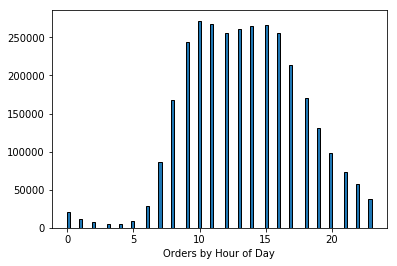

In [21]:
plt.hist(df_prior_set.order_hour_of_day, bins=100 , edgecolor='black')
plt.xlabel('Orders by Hour of Day')


Hour of day indicates most orders between 8am and 8pm which makes sense. 

Looking at Days since prior order:

Text(0.5,0,u'Days since prior order')

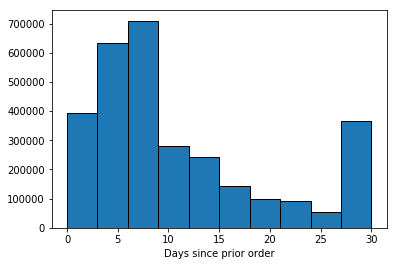

In [22]:
plt.hist(df_prior_set.days_since_prior_order.dropna(),edgecolor='black')
plt.xlabel("Days since prior order")

It looks like most orders are followed by another order with in the week. 

The previous data set did not have any describtion on the contents of the order. That information is contained in order_products csv files. Lets explore that for a minute. 

In [23]:
#lets load another chunk of data and look around
instacart_file2=pd.read_csv('Data/order_products__prior.csv')
df_products_prior=pd.DataFrame(instacart_file2,)
df_products_prior.head(12)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
5,2,17794,6,1
6,2,40141,7,1
7,2,1819,8,1
8,2,43668,9,0
9,3,33754,1,1


We have each order uniquely identified by order id, each product uniquely identified by product_id, the order in which each product was added to the cart and if the product/item was a reorder.

In [24]:
df_products_prior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
order_id             int64
product_id           int64
add_to_cart_order    int64
reordered            int64
dtypes: int64(4)
memory usage: 989.8 MB


In [25]:
df_products_prior.nunique()

order_id             3214874
product_id             49677
add_to_cart_order        145
reordered                  2
dtype: int64

Lets explore reorders

In [26]:
#group by order_id for reorders
reorders_by_order=df_products_prior['reordered'].groupby(df_products_prior['order_id']).sum()

In [27]:
reorders_by_order.describe()


count    3.214874e+06
mean     5.949389e+00
std      5.842059e+00
min      0.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      8.000000e+00
max      1.300000e+02
Name: reordered, dtype: float64

In [28]:
reorders_by_order.median()

4.0

Reorders per order range from none to 130. Order average almost 6 reorders and a median of 4 reorders.

Text(0.5,0,u'reorders by order')

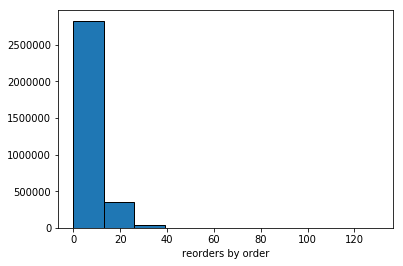

In [29]:
plt.hist(reorders_by_order,edgecolor='black')
plt.xlabel("reorders by order")


The 130 reorder seems to appear to be an outlier. Most reorders are below 40 with the majority below 20.

Lets look at what portion of the order is reorders.

In [30]:
#count reorders by grouping by order_id on the reordered column
items_in_order=df_products_prior['reordered'].groupby(df_products_prior['order_id']).count()

([<matplotlib.patches.Wedge at 0x104c03f50>,
 [Text(0.305886,1.05661,u'non-reorders'),
  Text(-0.305886,-1.05661,u'reorders')],
 [Text(0.166847,0.576335,u'41.0%'), Text(-0.166847,-0.576335,u'59.0%')])

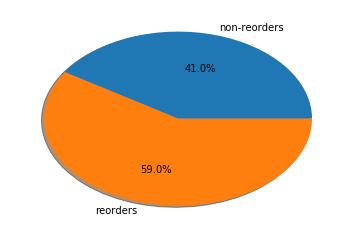

In [31]:
#plot the portion
plt.pie([(items_in_order.sum()-reorders_by_order.sum()),reorders_by_order.sum()],labels=['non-reorders','reorders'],autopct='%1.1f%%', shadow=True)

In [32]:
print(reorders_by_order.sum(),":reordered items",items_in_order.sum(),":items ordered")

(19126536L, ':reordered items', 32434489L, ':items ordered')


Most orders contian around 60% reorders.

In [33]:
print( type(items_in_order),type(reorders_by_order))

(<class 'pandas.core.series.Series'>, <class 'pandas.core.series.Series'>)


In [34]:
#dataframe to easily see portion of reorders
df_order_totals=pd.concat([items_in_order,reorders_by_order], axis=1, 
                          join='inner',keys=['items_n_order','reorders_n_order'])

df_order_totals['pct_reorders']=df_order_totals.reorders_n_order/df_order_totals.items_n_order
df_order_totals.head()

,items_n_order,reorders_n_order,pct_reorders
order_id,,,
2,9,6,0.666667
3,8,8,1.000000
4,13,12,0.923077
5,26,21,0.807692
6,3,0,0.000000


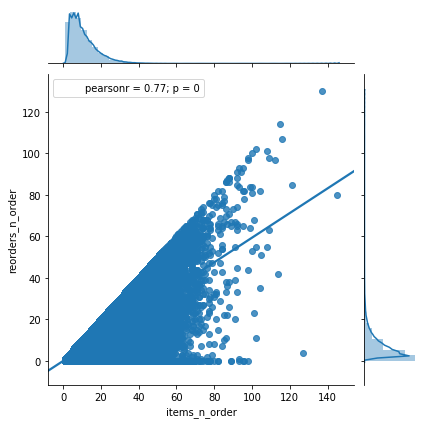

In [35]:
sns.jointplot('items_n_order','reorders_n_order', data=df_order_totals, kind='reg')

In [36]:
reorders_n_orders=df_order_totals.groupby('reorders_n_order').count()
reorders_n_orders.rename(columns={'items_n_order':'freq','pct_reorders':'reorders per order by count'},inplace=True)
reorders_n_orders.sort_values('reorders per order by count',ascending=False).head(10)

,freq,reorders per order by count
reorders_n_order,,
0,388513,388513
2,330770,330770
1,327898,327898
3,312493,312493
4,281704,281704
5,246626,246626
6,211744,211744
7,180083,180083
8,152229,152229


Not to surprising orders with 0 reorders are the most common. The only intersting point people seem to reorder 2 items more often then just one item. The likelihood of reorders diminshes with increasing order size after that.  

In [37]:
high_pct_reorders=df_order_totals.groupby(pd.cut(df_order_totals["pct_reorders"], np.arange(0, 1.0, 0.1))).sum()
high_pct_reorders["order count per %"]=df_order_totals['items_n_order'].groupby(pd.cut(df_order_totals["pct_reorders"], np.arange(0, 1.0, 0.1))).count()
high_pct_reorders["pct_reorders"]=high_pct_reorders.reorders_n_order/high_pct_reorders['items_n_order']
high_pct_reorders.rename(columns={'items_n_order':'total_items_n_bracket','reorders_n_order':'total_reorders_n_bracket'},inplace=True)
high_pct_reorders.sort_values('order count per %',ascending=False)

,total_items_n_bracket,total_reorders_n_bracket,pct_reorders,order count per %
pct_reorders,,,,
"(0.7, 0.8]",4059070,3071363,0.756667,347881
"(0.4, 0.5]",3172981,1482753,0.467306,316473
"(0.8, 0.9]",3829141,3277139,0.855842,293627
"(0.6, 0.7]",3369727,2212437,0.656563,284693
"(0.3, 0.4]",2447176,875706,0.357843,229923
"(0.5, 0.6]",2761974,1561753,0.565448,213822
"(0.2, 0.3]",1787884,461661,0.258216,155163
"(0.1, 0.2]",1511068,240899,0.159423,141139
"(0.0, 0.1]",532566,40389,0.075838,35263


The above table show Orders with 70% to 80% reorders had the highest volume.

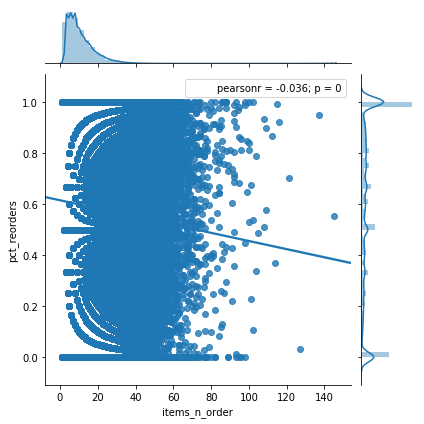

In [38]:
sns.jointplot('items_n_order','pct_reorders', data=df_order_totals, kind='reg')

In [39]:
#count orders without any reorders in all previous orders (prior set)
orders_wo_reorders=df_order_totals['reorders_n_order'][df_order_totals['reorders_n_order']==0].count()
#count number of orders in prior set (all previous orders)
total_orders=df_order_totals['reorders_n_order'].count()
#calculate empirical probability of orders without reorders
prob_no_reorder=orders_wo_reorders/float(total_orders)
print ("Out of {} orders the probability of not reordering any items is {:.0f}%".format( total_orders , prob_no_reorder*100))

Out of 3214874 orders the probability of not reordering any items is 12%


In [40]:
total_orders=df_order_totals['reorders_n_order'].count()

In [41]:
products_in_order=df_products_prior['order_id'].groupby(df_products_prior['product_id']).nunique()
products_in_order=products_in_order.sort_values(ascending=False)
products_in_order.head(10)

product_id
24852    472565
13176    379450
21137    264683
21903    241921
47209    213584
47766    176815
47626    152657
16797    142951
26209    140627
27845    137905
Name: order_id, dtype: int64

In [42]:
#lets load the product names
instacart_products=pd.read_csv('Data/products.csv')
df_ic_prod=pd.DataFrame(instacart_products,)
df_ic_prod.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [43]:
products_in_order=pd.DataFrame(products_in_order)
products_in_order.rename(columns={'order_id':'purchases'},inplace=True)
products_in_order.head()

,purchases
product_id,
24852,472565
13176,379450
21137,264683
21903,241921
47209,213584


In [44]:
products_in_order=pd.merge(df_ic_prod,products_in_order, how= 'outer',left_on="product_id" , right_index= True)


In [45]:
products_in_order.head()

,product_id,product_name,aisle_id,department_id,purchases
0,1,Chocolate Sandwich Cookies,61,19,1852.0
1,2,All-Seasons Salt,104,13,90.0
2,3,Robust Golden Unsweetened Oolong Tea,94,7,277.0
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,329.0
4,5,Green Chile Anytime Sauce,5,13,15.0


In [46]:
top_sellers=products_in_order.set_index('product_name')


In [47]:
top_sellers=top_sellers.sort_values(by='purchases',ascending=False).head(15)
top_sellers


,product_id,aisle_id,department_id,purchases
product_name,,,,
Banana,24852,24,4,472565.0
Bag of Organic Bananas,13176,24,4,379450.0
Organic Strawberries,21137,24,4,264683.0
Organic Baby Spinach,21903,123,4,241921.0
Organic Hass Avocado,47209,24,4,213584.0
Organic Avocado,47766,24,4,176815.0
Large Lemon,47626,24,4,152657.0
Strawberries,16797,24,4,142951.0
Limes,26209,24,4,140627.0


Text(0.5,1,u'best sellers')

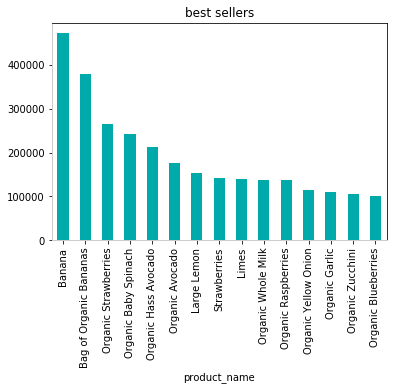

In [48]:

ax = top_sellers.purchases.plot(kind='bar',facecolor='#00AAAA')

ax.patch.set_facecolor('#FFFFFF')
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['left'].set_linewidth(1)
ax.set_title('best sellers')


Lets see which products get reordered the most.

In [49]:
products_reordered=df_products_prior['reordered'].groupby(df_products_prior['product_id']).sum()
products_reordered=products_reordered.sort_values(ascending=False)
products_reordered.head(15)

product_id
24852    398609
13176    315913
21137    205845
21903    186884
47209    170131
47766    134044
27845    114510
47626    106255
27966    105409
16797     99802
26209     95768
22935     79072
24964     74663
45007     72165
49683     67313
Name: reordered, dtype: int64

In [50]:
products_reordered=pd.DataFrame(products_reordered)

In [51]:
products_reordered.head()

,reordered
product_id,
24852,398609
13176,315913
21137,205845
21903,186884
47209,170131


In [52]:
products_in_order=pd.merge(products_in_order,products_reordered, how= 'outer',left_on="product_id", right_index= True)
products_in_order.head()


,product_id,product_name,aisle_id,department_id,purchases,reordered
0,1,Chocolate Sandwich Cookies,61,19,1852.0,1136.0
1,2,All-Seasons Salt,104,13,90.0,12.0
2,3,Robust Golden Unsweetened Oolong Tea,94,7,277.0,203.0
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,329.0,147.0
4,5,Green Chile Anytime Sauce,5,13,15.0,9.0


In [53]:
top_reorders=products_in_order.set_index('product_name')
top_reorders=top_reorders.sort_values(by='reordered',ascending=False).head(15)
top_reorders


,product_id,aisle_id,department_id,purchases,reordered
product_name,,,,,
Banana,24852,24,4,472565.0,398609.0
Bag of Organic Bananas,13176,24,4,379450.0,315913.0
Organic Strawberries,21137,24,4,264683.0,205845.0
Organic Baby Spinach,21903,123,4,241921.0,186884.0
Organic Hass Avocado,47209,24,4,213584.0,170131.0
Organic Avocado,47766,24,4,176815.0,134044.0
Organic Whole Milk,27845,84,16,137905.0,114510.0
Large Lemon,47626,24,4,152657.0,106255.0
Organic Raspberries,27966,123,4,137057.0,105409.0


Text(0.5,1,u'top reorders')

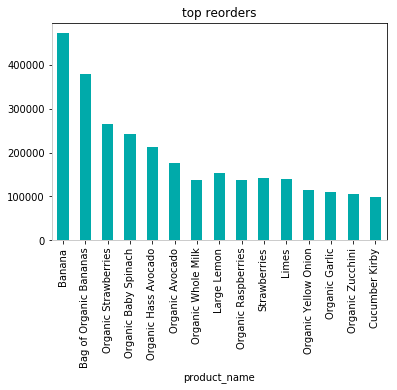

In [54]:

ax = top_reorders.purchases.plot(kind='bar',facecolor='#00AAAA')

ax.patch.set_facecolor('#FFFFFF')
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['left'].set_linewidth(1)
ax.set_title('top reorders')


Lets see what product has the highest chance of being reordered. We will use the empirecal data of reorders divided by purchases(oppurtunity to reorder) has the probability of reorder.

In [55]:
#calculate portion of reorders and assign to new column
products_in_order['portion']=products_in_order.reordered/products_in_order.purchases
products_in_order.head()

,product_id,product_name,aisle_id,department_id,purchases,reordered,portion
0,1,Chocolate Sandwich Cookies,61,19,1852.0,1136.0,0.613391
1,2,All-Seasons Salt,104,13,90.0,12.0,0.133333
2,3,Robust Golden Unsweetened Oolong Tea,94,7,277.0,203.0,0.732852
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,329.0,147.0,0.446809
4,5,Green Chile Anytime Sauce,5,13,15.0,9.0,0.600000


In [56]:
#set product name as index
top_sellers=products_in_order.set_index('product_name')
top_sellers=top_sellers.sort_values(by='purchases',ascending=False).head(15)
top_sellers

,product_id,aisle_id,department_id,purchases,reordered,portion
product_name,,,,,,
Banana,24852,24,4,472565.0,398609.0,0.843501
Bag of Organic Bananas,13176,24,4,379450.0,315913.0,0.832555
Organic Strawberries,21137,24,4,264683.0,205845.0,0.777704
Organic Baby Spinach,21903,123,4,241921.0,186884.0,0.772500
Organic Hass Avocado,47209,24,4,213584.0,170131.0,0.796553
Organic Avocado,47766,24,4,176815.0,134044.0,0.758103
Large Lemon,47626,24,4,152657.0,106255.0,0.696038
Strawberries,16797,24,4,142951.0,99802.0,0.698155
Limes,26209,24,4,140627.0,95768.0,0.681007


In [57]:
top_portion=products_in_order.set_index('product_name')
top_portion=top_portion.sort_values(by='portion',ascending=False).head(15)
top_portion

,product_id,aisle_id,department_id,purchases,reordered,portion
product_name,,,,,,
Raw Veggie Wrappers,6433,13,20,68.0,64.0,0.941176
Serenity Ultimate Extrema Overnight Pads,2075,126,11,87.0,81.0,0.931034
Orange Energy Shots,43553,64,7,13.0,12.0,0.923077
Chocolate Love Bar,27740,45,19,101.0,93.0,0.920792
Soy Powder Infant Formula,14609,92,18,35.0,32.0,0.914286
Simply Sleep Nighttime Sleep Aid,13875,6,2,45.0,41.0,0.911111
"Energy Shot, Grape Flavor",39992,64,7,22.0,20.0,0.909091
Russian River Valley Reserve Pinot Noir,5868,28,5,30.0,27.0,0.900000
Sparking Water,31418,115,7,60.0,54.0,0.900000


Text(0.5,1,u'top probability of reorder')

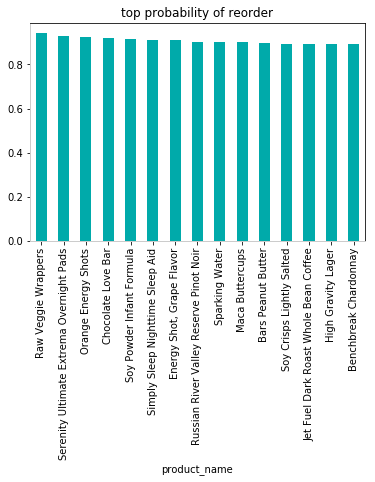

In [58]:
#plot portion column
ax = top_portion.portion.plot(kind='bar',facecolor='#00AAAA')

ax.patch.set_facecolor('#FFFFFF')
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['left'].set_linewidth(1)
ax.set_title('top probability of reorder')



In [59]:
#group features by departments and sum products bought by department sort departments by top reorders first
departments=products_in_order.groupby('department_id').sum().sort_values('reordered',ascending=False)
#drop columns that are useless now
departments=departments.drop(['product_id','aisle_id'],axis=1)
#assign portion column to reorder rate of department
departments['portion']=departments['reordered']/departments['purchases']
departments=departments.reset_index()

In [60]:
#lets load department names
instacart_departments=pd.read_csv('/Users/luca/anaconda2/Springboard/Capstone Project 1/Data/departments.csv')
df_departments=pd.DataFrame(instacart_departments)
df_departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [61]:
#merge department names into data frame for graphing 
departments=pd.merge(departments,df_departments, how= 'outer',right_on="department_id" , left_on="department_id")
departments.head()

,department_id,purchases,reordered,portion,department
0,4,9479291.0,6160710.0,0.649913,produce
1,16,5414016.0,3627221.0,0.669969,dairy eggs
2,7,2690129.0,1757892.0,0.653460,beverages
3,19,2887550.0,1657973.0,0.574180,snacks
4,1,2236432.0,1211890.0,0.541885,frozen


In [62]:
#set index for graphing
departments=departments.set_index('department')

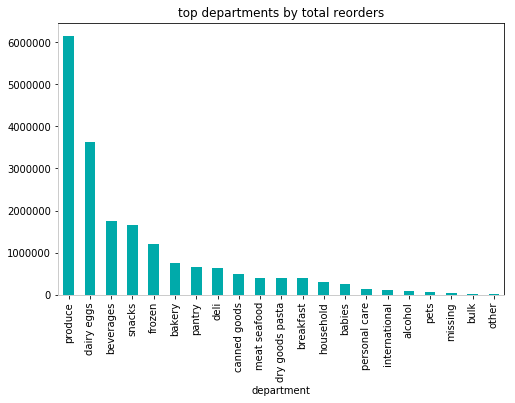

In [63]:
#sort data frame by reorders
departments=departments.sort_values('reordered', ascending=False)
#create figure instance
fig,ax=plt.subplots(figsize=(8,5))
#plot reordered by department bar graph
ax = departments.reordered.plot(kind='bar',facecolor='#00AAAA')
#set x tick labels
ax.set_xticklabels(departments.index)
#set some formating 
ax.patch.set_facecolor('#FFFFFF')
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['left'].set_linewidth(1)
#set title for graph
ax.set_title('top departments by total reorders')
#to prevent saving from cutting edges
plt.tight_layout()
#save figure for paper
fig.savefig('top_dept_tot_reorder.png'
#show
plt.show()

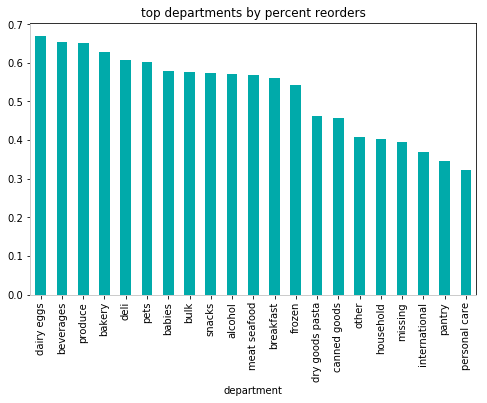

In [64]:
#sort departments by portion of reorders to purchases
departments=departments.sort_values('portion', ascending=False)
#create figure instance
fig,ax=plt.subplots(figsize=(8,5))
#make a bar chart with a cool blue color
ax = departments.portion.plot(kind='bar',facecolor='#00AAAA')
#set names of department as x labels
ax.set_xticklabels(departments.index)
#some more formating
ax.patch.set_facecolor('#FFFFFF')
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['left'].set_linewidth(1)
#set title for graph
ax.set_title('top departments by percent reorders')
#to prevent saving from cutting edges
plt.tight_layout()
#save and show figure for paper
fig.savefig('top_dept_perc_reorder.png')
plt.show()

We see that perishable items are the leading reorders in volume and percent of purchases. Lets see if the aisle data provides any insight.


In [65]:
#group features by departments and sum products bought by department sort departments by top reorders first
aisle=products_in_order.groupby('aisle_id').sum().sort_values('reordered',ascending=False)
#drop columns that are useless now
aisle=aisle.drop(['product_id','department_id'],axis=1)
#assign portion column to reorder rate of department
aisle['portion']=aisle['reordered']/aisle['purchases']
aisle=aisle.reset_index()

In [66]:
#lets load aisles' names
instacart_aisles=pd.read_csv('/Users/luca/anaconda2/Springboard/Capstone Project 1/Data/aisles.csv')
df_aisles=pd.DataFrame(instacart_aisles)
df_aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [67]:
#merge department names into data frame for graphing 
aisle=pd.merge(aisle,df_aisles, how= 'outer',right_on="aisle_id" , left_on="aisle_id")
aisle.head()

,aisle_id,purchases,reordered,portion,aisle
0,24,3642188.0,2615469.0,0.718104,fresh fruits
1,83,3418021.0,2032172.0,0.594546,fresh vegetables
2,123,1765313.0,1127177.0,0.638514,packaged vegetables fruits
3,120,1452343.0,997018.0,0.686489,yogurt
4,84,891015.0,696264.0,0.781428,milk


In [68]:
#set index for graphing
aisle=aisle.set_index('aisle')

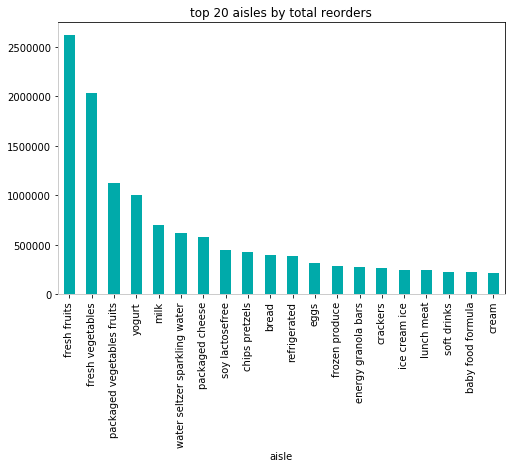

In [69]:
#sort departments by portion of reorders to purchases
aisle_top=aisle.sort_values('reordered', ascending=False).head(20)
#create figure instance
fig,ax=plt.subplots(figsize=(8,5))
#plot reordered by department bar graph
ax = aisle_top.reordered.plot(kind='bar',facecolor='#00AAAA',)
#set x tick labels
ax.set_xticklabels(aisle_top.index)
#set some formating 
ax.patch.set_facecolor('#FFFFFF')
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['left'].set_linewidth(1)
#set title for graph
ax.set_title('top 20 aisles by total reorders')
#to prevent saving from cutting edges
plt.tight_layout()
#save and show figure for paper
fig.savefig('top_aisle_tot_reorder.png')
plt.show()

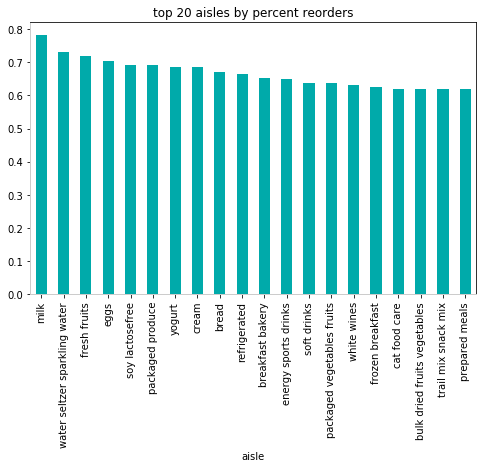

In [70]:
#sort departments by portion of reorders to purchases
aisle_top=aisle.sort_values('portion', ascending=False).head(20)
#create figure instance
fig,ax=plt.subplots(figsize=(8,5))
#make a bar chart with a cool blue color
ax = aisle_top.portion.plot(kind='bar',facecolor='#00AAAA')
#set names of department as x labels
ax.set_xticklabels(aisle_top.index)
#some more formating
ax.patch.set_facecolor('#FFFFFF')
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['left'].set_linewidth(1)
#set title for graph
ax.set_title('top 20 aisles by percent reorders')
#to prevent saving from cutting edges
plt.tight_layout()
#save and show figure for paper
fig.savefig('top_aisle_perc_reorder.png')
plt.show()

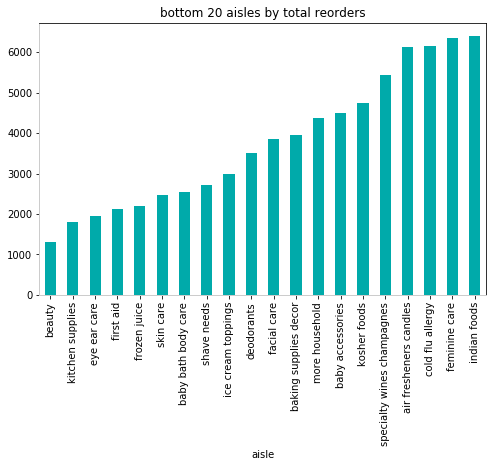

In [71]:
#sort departments by portion of reorders to purchases
aisle_bot=aisle.sort_values('reordered').head(20)
#create figure instance
fig,ax=plt.subplots(figsize=(8,5))
#make a bar chart with a cool blue color
ax = aisle_bot.reordered.plot(kind='bar',facecolor='#00AAAA')
#set names of department as x labels
ax.set_xticklabels(aisle_bot.index)
#some more formating
ax.patch.set_facecolor('#FFFFFF')
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['left'].set_linewidth(1)
#set title for graph
ax.set_title('bottom 20 aisles by total reorders')
#to prevent saving from cutting edges
plt.tight_layout()
#save and show figure for paper
fig.savefig('bottom_aisle_total_reorders.png')
plt.show()

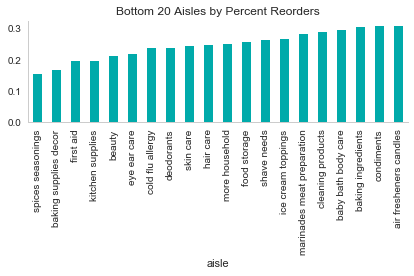

In [155]:
#sort departments by portion of reorders to purchases
aisle_bot=aisle.sort_values('portion').head(20)

#make a bar chart with a cool blue color
ax = aisle_bot.portion.plot(kind='bar',facecolor='#00AAAA')
#set names of department as x labels
ax.set_xticklabels(aisle_bot.index)
#some more formating
ax.patch.set_facecolor('#FFFFFF')
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['left'].set_linewidth(1)
#set title for graph

ax.set_title('Bottom 20 Aisles by Percent Reorders')
#to prevent saving from cutting edges
plt.tight_layout()
#save and show figure for paper
fig.savefig('bottom_aisle_perc_reorders.png')
plt.show()

In [73]:
print(aisle_top.portion.head(5))

aisle
milk                             0.781428
water seltzer sparkling water    0.729593
fresh fruits                     0.718104
eggs                             0.705366
soy lactosefree                  0.692551
Name: portion, dtype: float64


In [74]:
top_sellers.head()

,product_id,aisle_id,department_id,purchases,reordered,portion
product_name,,,,,,
Banana,24852,24,4,472565.0,398609.0,0.843501
Bag of Organic Bananas,13176,24,4,379450.0,315913.0,0.832555
Organic Strawberries,21137,24,4,264683.0,205845.0,0.777704
Organic Baby Spinach,21903,123,4,241921.0,186884.0,0.772500
Organic Hass Avocado,47209,24,4,213584.0,170131.0,0.796553


In [75]:
#function to plot empirical cumulative distribution
def ecdf(data):
    """ Compute Empirical Cumulative Distribution Functions for an array of 1 dimensional elements
    """
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.linspace(1./n,1,n)
    return x,y

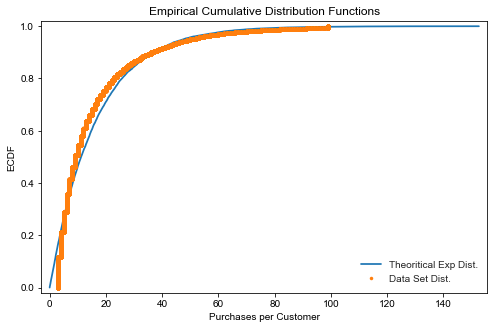

In [76]:
# plot data distribution against a similiar normal distribution

# Sample out of a normal distribution with this mu and sigma: samples
samples = np.random.exponential(16,size=10000)

# Get the CDF of the samples and of the data
x_theory , y_theory = ecdf(samples)
x , y = ecdf(user_order_count)

fig,ax=plt.subplots(figsize=(8,5))
#make a bar chart with a cool blue color
# Plot the CDFs and show the plot
sns.set()
_ = plt.plot(x_theory, y_theory,label='Theoritical Exp Dist.')
_ = plt.plot(x, y, marker='.', linestyle='none',label='Data Set Dist.')

plt.margins(0.02)

_ = plt.xlabel('Purchases per Customer', {'fontsize': 14})
_ = plt.ylabel('ECDF', {'fontsize': 14})
_ = plt.legend(loc=4)
plt.title('Empirical Cumulative Distribution Functions', {'fontsize': 14})

#to prevent saving from cutting edges
plt.tight_layout()

#save figure for paper
plt.savefig('ecdf_purchases.png')

plt.show()


We see that the customer purchase data is approximated by a exponential distribution with mean 16. If we want to know the number of purchases 95% of customers purchased, then 
P(x < k ) = .95 Using the exponential distribution, we then have (1/16)e^-(1/16)k = .95 The CDF gives us the area to the left then 1-P(x<K), hence our equation is 1-(1/16)e^-(1/16)k = 1-.95=.05 Solve for k. Take the natural log and divide, we end up with k =ln(0.5)/(-1/16) 

In [77]:
user_order_count.describe()

count    206209.000000
mean         15.590367
std          16.654774
min           3.000000
25%           5.000000
50%           9.000000
75%          19.000000
max          99.000000
Name: order_number, dtype: float64

lets set the mean to 16 to the exp distribution function and calculate 

In [78]:
#set the mean to 16
mean=16.0
#calculate the purchused items or less number for 95% of customers
k= np.log(0.05)/(-1/mean)
print('95% of customers purchased {:.00f} items or less'.format(k))

95% of customers purchased 48 items or less


In [79]:
def prob_items(prob,mean):
    '''prob is the probability to the left of the CDF,
    mean is the mean of the exp distibution to use
    returns float of items purchased at the probability level '''
    prob1=1-prob
    k=np.log(prob1)/(-1/mean)
    prob=prob*100
    print('{:.00f}% of customers purchased {:.00f} items or less'.format(prob,k))
    k=int('{:.00f}'.format(k))
    return k

In [80]:
#lets compare 
prob_items(.66, 16.0)
prob_items(.95, 16.0)
prob_items(.99, 16.0)

66% of customers purchased 17 items or less
95% of customers purchased 48 items or less
99% of customers purchased 74 items or less


74

In [156]:
#lets calculate the reorder probabilities 
prob_items(.66, 6.0)
prob_items(.95, 6.0)
prob_items(.99, 6.0)

66% of customers purchased 6 items or less
95% of customers purchased 18 items or less
99% of customers purchased 28 items or less


28

In [81]:
user_order_count.head()

user_id
1    10
2    14
3    12
4     5
5     4
Name: order_number, dtype: int64

In [82]:
prob_range=[.66,.95,.99]

for i in prob_range:
    
    items_=prob_items(i,16.0)
    users_=user_order_count[user_order_count<=items_].count()
    print("there were {} customers that purchased this many\n".format(users_))

66% of customers purchased 17 items or less
there were 148888 customers that purchased this many

95% of customers purchased 48 items or less
there were 194745 customers that purchased this many

99% of customers purchased 74 items or less
there were 202756 customers that purchased this many



We see that most of our customers purchased less than 74 items at a visit. We could use these numbers to reduce the data since are data is so large. However, we would be excluding some of the most lucrative customers from the reorder prediction model. Of course these outlier customers might be using InstaCart differently than the typical customer and could warrant special consideration.  

In [83]:
top_portion.head()

,product_id,aisle_id,department_id,purchases,reordered,portion
product_name,,,,,,
Raw Veggie Wrappers,6433,13,20,68.0,64.0,0.941176
Serenity Ultimate Extrema Overnight Pads,2075,126,11,87.0,81.0,0.931034
Orange Energy Shots,43553,64,7,13.0,12.0,0.923077
Chocolate Love Bar,27740,45,19,101.0,93.0,0.920792
Soy Powder Infant Formula,14609,92,18,35.0,32.0,0.914286


Text(0.5,1,u'top sellers frequency of reorders binned')

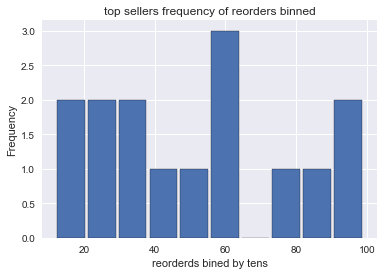

In [84]:
top_portion['reordered'].plot(kind='hist',edgecolor='black',rwidth=.9,align='mid')
plt.xlabel('reorderds bined by tens', {'fontsize': 14})
plt.title("top sellers frequency of reorders binned", {'fontsize': 14})


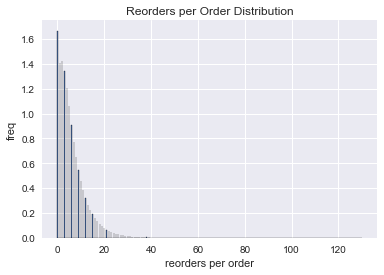

In [85]:
sns.set()
n_data=len(reorders_by_order)

# Number of bins is the square root of number of data points: n_bins
n_bins=np.sqrt(n_data)
n_bins=int(n_bins)

# Plot the histogram
_= plt.hist(reorders_by_order,bins=n_bins,normed=True,edgecolor='black')
_= plt.xlabel('reorders per order')
_= plt.ylabel('freq')
_= plt.title('Reorders per Order Distribution')

 #Show histogram
plt.show()



In [86]:
reorders_by_order.describe()

count    3.214874e+06
mean     5.949389e+00
std      5.842059e+00
min      0.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      8.000000e+00
max      1.300000e+02
Name: reordered, dtype: float64

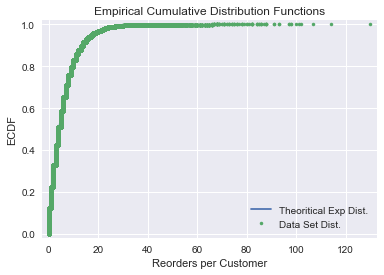

In [87]:
# plot data distribution against a similiar normal distribution

# Sample out of a normal distribution with this mu and sigma: samples
samples = np.random.exponential(6,size=10000)

# Get the CDF of the samples and of the data
x_theory , y_theory = ecdf(samples)
x , y = ecdf(reorders_by_order)


# Plot the CDFs and show the plot
sns.set()
_ = plt.plot(x_theory, y_theory,label='Theoritical Exp Dist.')
_ = plt.plot(x, y, marker='.', linestyle='none',label='Data Set Dist.')

plt.margins(0.02)

_ = plt.xlabel('Reorders per Customer', {'fontsize': 14})
_ = plt.ylabel('ECDF', {'fontsize': 14})
_ = plt.legend(loc=4)
_ = plt.title('Empirical Cumulative Distribution Functions', {'fontsize': 14})

#to prevent saving from cutting edges
plt.tight_layout()

#save figure for paper
plt.savefig('ecdf_reorders.png')


plt.show()

Text(0,0.5,u'reorder count')

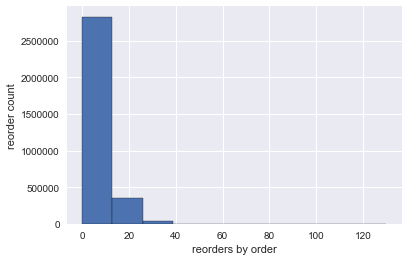

In [88]:
plt.hist(reorders_by_order,edgecolor='black')
plt.xlabel("reorders by order", {'fontsize': 14})
plt.ylabel("reorder count", {'fontsize': 14})

In [89]:
from collections import Counter
reordered_freq=Counter(reorders_by_order)
reordered_freq

Counter({0: 388513,
         1: 327898,
         2: 330770,
         3: 312493,
         4: 281704,
         5: 246626,
         6: 211744,
         7: 180083,
         8: 152229,
         9: 126646,
         10: 106154,
         11: 88972,
         12: 74583,
         13: 62460,
         14: 52783,
         15: 43953,
         16: 37105,
         17: 30915,
         18: 25906,
         19: 21563,
         20: 18177,
         21: 15206,
         22: 12746,
         23: 10761,
         24: 9121,
         25: 7534,
         26: 6419,
         27: 5342,
         28: 4381,
         29: 3632,
         30: 3000,
         31: 2491,
         32: 2073,
         33: 1786,
         34: 1474,
         35: 1260,
         36: 975,
         37: 855,
         38: 728,
         39: 620,
         40: 477,
         41: 417,
         42: 345,
         43: 295,
         44: 224,
         45: 219,
         46: 147,
         47: 153,
         48: 132,
         49: 96,
         50: 89,
         51: 80,
      

In [90]:
reorders_by_order[reorders_by_order==130]

order_id
790903    130
Name: reordered, dtype: int64

In [91]:
df_prior_set[df_prior_set['order_id']==790903]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
2159899,790903,129928,prior,38,6,23,5.0


In [92]:
df_products_prior[df_products_prior['order_id']==790903].sum()

order_id             108353711
product_id             3466547
add_to_cart_order         9453
reordered                  130
dtype: int64

In [93]:
df_products_prior[df_products_prior['order_id']==790903].count()

order_id             137
product_id           137
add_to_cart_order    137
reordered            137
dtype: int64

In [94]:
df_products_prior[df_products_prior['order_id']==790903]

,order_id,product_id,add_to_cart_order,reordered
7492419,790903,34281,1,0
7492420,790903,3957,2,1
7492421,790903,43193,3,0
7492422,790903,13176,4,1
7492423,790903,45840,5,1
7492424,790903,25718,6,1
7492425,790903,22159,7,1
7492426,790903,9421,8,1
7492427,790903,35121,9,1
7492428,790903,20084,10,1


In [95]:
sum(reordered_freq.values())

3214874

In [96]:
pd.Series(reordered_freq.values()).describe()

count        98.000000
mean      32804.836735
std       82152.951015
min           1.000000
25%           3.250000
50%         114.000000
75%        8724.250000
max      388513.000000
dtype: float64

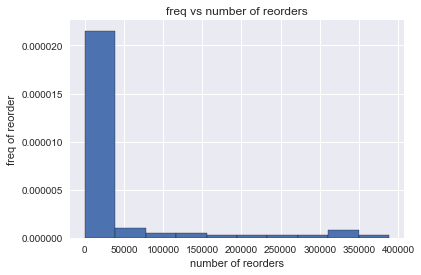

In [97]:
#plot the barchart of points per cluster

#get x-axis range from len and make a list of the dict values
#plt.bar(range(len(reordered_freq)),list(reordered_freq.values()))
_= plt.hist(x=reordered_freq.values(),normed=True,edgecolor='black')
#match score with key value and label x-axis appropriately
#plt.xticks(range(len(reordered_freq)),list(reordered_freq.keys()),rotation='vertical')

#add labels and title
_ = plt.xlabel('number of reorders')
_ = plt.ylabel('freq of reorder')
_ = plt.title('freq vs number of reorders')

plt.show()

Reorders which is a subset of purchases also follow the exponential distribution. However, this might give us a better look at predicting orders for the typical customer. The mean is 

In [98]:
top_sellers.purchases

product_name
Banana                    472565.0
Bag of Organic Bananas    379450.0
Organic Strawberries      264683.0
Organic Baby Spinach      241921.0
Organic Hass Avocado      213584.0
Organic Avocado           176815.0
Large Lemon               152657.0
Strawberries              142951.0
Limes                     140627.0
Organic Whole Milk        137905.0
Organic Raspberries       137057.0
Organic Yellow Onion      113426.0
Organic Garlic            109778.0
Organic Zucchini          104823.0
Organic Blueberries       100060.0
Name: purchases, dtype: float64

In [99]:
top_reorders.reordered

product_name
Banana                    398609.0
Bag of Organic Bananas    315913.0
Organic Strawberries      205845.0
Organic Baby Spinach      186884.0
Organic Hass Avocado      170131.0
Organic Avocado           134044.0
Organic Whole Milk        114510.0
Large Lemon               106255.0
Organic Raspberries       105409.0
Strawberries               99802.0
Limes                      95768.0
Organic Yellow Onion       79072.0
Organic Garlic             74663.0
Organic Zucchini           72165.0
Cucumber Kirby             67313.0
Name: reordered, dtype: float64

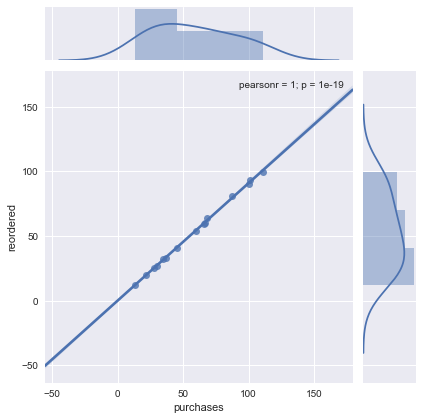

In [100]:
sns.jointplot('purchases','reordered', data=top_portion, kind='reg')



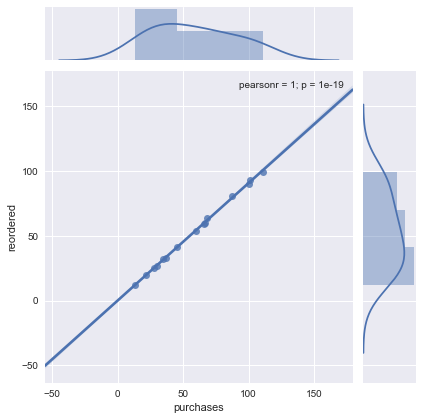

In [101]:
sns.jointplot('purchases','reordered', data=top_portion, kind='reg')



In [102]:
top_portion

,product_id,aisle_id,department_id,purchases,reordered,portion
product_name,,,,,,
Raw Veggie Wrappers,6433,13,20,68.0,64.0,0.941176
Serenity Ultimate Extrema Overnight Pads,2075,126,11,87.0,81.0,0.931034
Orange Energy Shots,43553,64,7,13.0,12.0,0.923077
Chocolate Love Bar,27740,45,19,101.0,93.0,0.920792
Soy Powder Infant Formula,14609,92,18,35.0,32.0,0.914286
Simply Sleep Nighttime Sleep Aid,13875,6,2,45.0,41.0,0.911111
"Energy Shot, Grape Flavor",39992,64,7,22.0,20.0,0.909091
Russian River Valley Reserve Pinot Noir,5868,28,5,30.0,27.0,0.900000
Sparking Water,31418,115,7,60.0,54.0,0.900000


In [103]:
df_reorder=pd.merge( df_products_prior , df_prior_set)

In [104]:
dow=df_reorder.groupby('order_dow').sum()
dow

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_hour_of_day,days_since_prior_order
order_dow,,,,,,,,
0,10618680435202,159428874233,54264718,3634366,640549007864,99446593,83847785,67183557.0
1,9686652116767,144982183354,47749596,3421285,583315940184,98079835,74255302,59982990.0
2,7200985487141,107784993833,34063143,2487537,434374507753,72898860,56600913,44579542.0
3,6581395510785,98061920285,30427580,2253698,395202639787,68137195,52074609,39192676.0
4,6488728974867,96629094575,30398454,2238166,389537642095,68162616,51612729,37526512.0
5,7202441161735,107508781949,35047154,2506649,432679907733,75707113,56302855,41345523.0
6,7708370332919,115159590224,38912222,2584835,463057114346,73561427,60738089,47269153.0


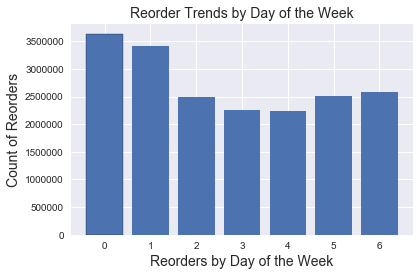

In [149]:
#plot reorder total by day of the week
plt.bar(dow.index,dow.reordered, edgecolor='black')
plt.xlabel("Reorders by Day of the Week", {'fontsize': 14})
plt.ylabel("Count of Reorders", {'fontsize': 14})
plt.title("Reorder Trends by Day of the Week", {'fontsize': 14})

#to prevent saving from cutting edges
plt.tight_layout()
#save figure for papers
plt.savefig('dow_reorders.png')
#show figure in notebook
plt.show()

In [106]:
hod=df_reorder.groupby('order_hour_of_day').sum()
hod

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,days_since_prior_order
order_hour_of_day,,,,,,,,
0,378024450755,5594732185,1881038,123815,22645473477,3459290,613673,2446677.0
1,199091534138,2952524969,991162,64506,12127455176,1782729,326543,1336711.0
2,118480118240,1773944311,590292,38498,7186376235,1093285,201339,776781.0
3,88003998677,1306157090,439711,28714,5379440447,835102,152830,594069.0
4,91439130232,1360712638,478330,30435,5475616828,906560,160789,629999.0
5,150439152069,2246512883,742138,53537,9082756219,1612046,261514,972794.0
6,493549122544,7426892999,2485356,185090,30047032790,5688365,846875,2944963.0
7,1520279594547,22771901903,7593644,574829,91563732754,17601754,2546136,8905789.0
8,2942333384164,43924609117,14672643,1086821,176536410235,32935579,4710240,17130101.0


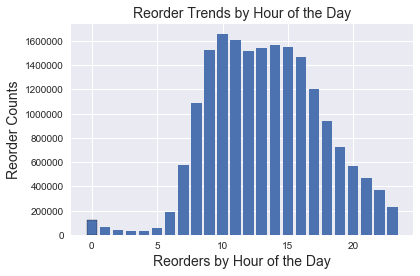

In [148]:
#plot reorder total by day of the week
plt.bar(hod.index,hod.reordered, edgecolor='black')
plt.xlabel("Reorders by Hour of the Day", {'fontsize': 14})
plt.ylabel("Reorder Counts", {'fontsize': 14})
plt.title("Reorder Trends by Hour of the Day", {'fontsize': 14})

#to prevent saving from cutting edges
plt.tight_layout()

#save figure
plt.savefig('hod_reorders.png')
#show figure in notebook
plt.show()

In [108]:
dspo=df_reorder.groupby('days_since_prior_order').sum()
dspo.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day
days_since_prior_order,,,,,,,,
0.0,768073603763,11467222177,3153029,331479,46308671426,12375945,1268232,6632249
1.0,1613272936116,24041366775,5597176,581256,97092419960,29700862,2736352,12872060
2.0,2507393087073,37410676737,9483833,945487,150178538629,44754438,4344317,19932874
3.0,3212072483625,47921833965,13499452,1255573,193178410444,53345774,5493365,25320690
4.0,3566712275458,53103415855,16129882,1409708,214692010966,53893254,5971579,27893039


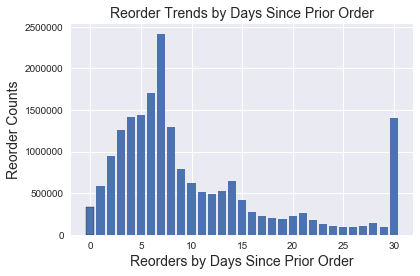

In [147]:
#plot reorder total by day of the week
plt.bar(dspo.index,dspo.reordered, edgecolor='black')
plt.xlabel("Reorders by Days Since Prior Order", {'fontsize': 14})
plt.ylabel('Reorder Counts', {'fontsize': 14})
plt.title("Reorder Trends by Days Since Prior Order", {'fontsize': 14})
#to prevent saving from cutting edges
plt.tight_layout()
#save figure for papers
plt.savefig('dspo_reorders.png')
#show figure in notebook
plt.show()

In [110]:
g = df_orders.groupby('user_id')
data_p1=g.last()
data_p1['order_from_last']=1
data_p1.head()

,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_from_last
user_id,,,,,,,
1,1187899,train,11,4,8,14.0,1
2,1492625,train,15,1,11,30.0,1
3,2774568,test,13,5,15,11.0,1
4,329954,test,6,3,12,30.0,1
5,2196797,train,5,0,11,6.0,1


In [111]:
df_orders.groupby('user_id').count().nunique()

order_id                  97
eval_set                  97
order_number              97
order_dow                 97
order_hour_of_day         97
days_since_prior_order    97
dtype: int64

We see that there are 97 previous orders for at least one customer. Lets look how the reorders have been behaving leading upto the last order. 

In [112]:
#capture the second to last order information for each user
data_p2=g.nth(-2)
data_p2['order_from_last']=2

In [113]:
#add reorders to second from last order (this is the test set moving forward)
reorders_p2=pd.merge( df_products_prior , data_p2 ,how='inner', left_on= "order_id" , right_on= 'order_id')
reorders_p2.head()

,order_id,product_id,add_to_cart_order,reordered,days_since_prior_order,eval_set,order_dow,order_hour_of_day,order_number,order_from_last
0,25,9755,1,1,25.0,prior,6,10,19,2
1,25,31487,2,0,25.0,prior,6,10,19,2
2,25,37510,3,1,25.0,prior,6,10,19,2
3,25,14576,4,1,25.0,prior,6,10,19,2
4,25,22105,5,0,25.0,prior,6,10,19,2


In [114]:
reorders_p2.head()

,order_id,product_id,add_to_cart_order,reordered,days_since_prior_order,eval_set,order_dow,order_hour_of_day,order_number,order_from_last
0,25,9755,1,1,25.0,prior,6,10,19,2
1,25,31487,2,0,25.0,prior,6,10,19,2
2,25,37510,3,1,25.0,prior,6,10,19,2
3,25,14576,4,1,25.0,prior,6,10,19,2
4,25,22105,5,0,25.0,prior,6,10,19,2


Text(0.5,1,u'2nd Previous Orders Reorder Percentage')

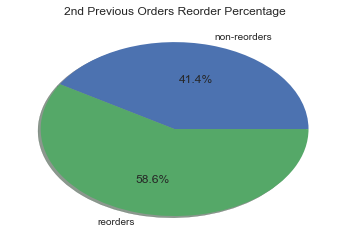

In [115]:
#count reorders by grouping by order_id on the reordered column
p2_items_in_order=reorders_p2['reordered'].groupby(reorders_p2['order_id']).count()
#group by order_id for reorders
p2_reorders_by_order=reorders_p2['reordered'].groupby(reorders_p2['order_id']).sum()
#plot the portion
plt.pie([(p2_items_in_order.sum()-p2_reorders_by_order.sum()),p2_reorders_by_order.sum()],labels=['non-reorders','reorders'],autopct='%1.1f%%', shadow=True)
plt.title("2nd Previous Orders Reorder Percentage")

In [116]:
reorders_=pd.merge( df_products_prior , df_orders ,how='inner', left_on= "order_id" , right_on= 'order_id')
reorders_.head()

#creat dictionary for tracking percentage for each previous reorder
order_delta={}
order_delta[2]=float(reorders_p2['reordered'].sum())/float(reorders_p2['reordered'].count())
order_delta

{2: 0.5863164949051027}

In [117]:
reorders_=pd.merge( df_products_prior , df_orders ,how='inner', left_on= "order_id" , right_on= 'order_id')
reorders_.head()

#creat dictionary for tracking percentage for each previous reorder
order_delta={}
for i in xrange(2,20,1):
    #capture the second to last order information for each user
    reorders_p=reorders_.groupby('user_id').nth(-i)
    order_delta[i]=float(reorders_p['reordered'].sum())/float(reorders_p['reordered'].count())
order_delta

{2: 0.3625205495395448,
 3: 0.3794354271637028,
 4: 0.3944653819255575,
 5: 0.40698783919304427,
 6: 0.4169267513590341,
 7: 0.4235774669988035,
 8: 0.4280977484357294,
 9: 0.4309043733164316,
 10: 0.4346668126922809,
 11: 0.4375653984990262,
 12: 0.4386532271470237,
 13: 0.4408743878575267,
 14: 0.4422847225766934,
 15: 0.4416510318949343,
 16: 0.44255109706499496,
 17: 0.4432938032403541,
 18: 0.44508125973643214,
 19: 0.44741715528906106}

In [118]:
reorders_p=reorders_.groupby('user_id').nth(-2)
float(reorders_p['reordered'].sum())/float(reorders_p['reordered'].count())

0.3625205495395448

In [119]:
reorders_.nunique()

order_id                  3214874
product_id                  49677
add_to_cart_order             145
reordered                       2
user_id                    206209
eval_set                        1
order_number                   99
order_dow                       7
order_hour_of_day              24
days_since_prior_order         31
dtype: int64

In [120]:
reorders_p.nunique()

add_to_cart_order             77
days_since_prior_order        31
eval_set                       1
order_dow                      7
order_hour_of_day             24
order_id                  206209
order_number                  99
product_id                 23867
reordered                      2
dtype: int64

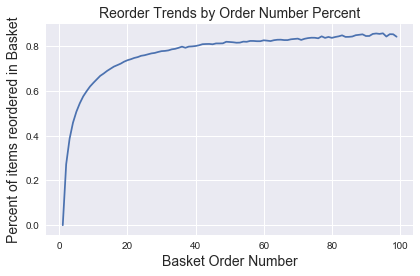

In [145]:
#create data frame to capture percent of reorders per order number under the reordered column 
df_order_number=reorders_.groupby("order_number").sum()/reorders_.groupby("order_number").count()

#plot reorder by order number (cumulative of all customer with that order number)
plt.plot( df_order_number.index, df_order_number.reordered)
#add labels and title
plt.xlabel("Basket Order Number", {'fontsize': 14})
plt.ylabel("Percent of items reordered in Basket", {'fontsize': 14})
plt.title("Reorder Trends by Order Number Percent", {'fontsize': 14})
#to prevent saving from cutting edges
plt.tight_layout()
#save figure for papers
plt.savefig('order_number_reorders.png')
#show figure in notebook
plt.show()

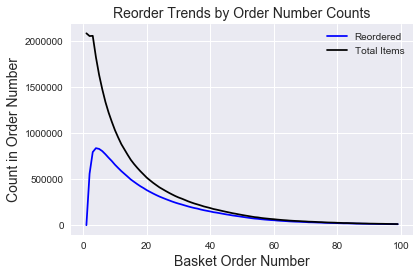

In [144]:
#plot reorders by order number
plt.plot( reorders_.groupby("order_number")['reordered'].sum(), c='b', label="Reordered")
plt.plot( reorders_.groupby("order_number")['reordered'].count(), c='k', label= "Total Items")
#add labels and title
plt.xlabel("Basket Order Number",fontsize= 14)
plt.ylabel("Count in Order Number", {'fontsize': 14})
plt.title("Reorder Trends by Order Number Counts", {'fontsize': 14})
plt.legend(loc=1)
#to prevent saving from cutting edges
plt.tight_layout()
#save figure for papers
plt.savefig('order_number_values.png')
#show figure in notebook
plt.show()



We see that the more orders a customer has the higher the rate of reorders per basket. Notice that the percent of reorders in the bakset level off just above 85%. The first order obviously has no reorders 

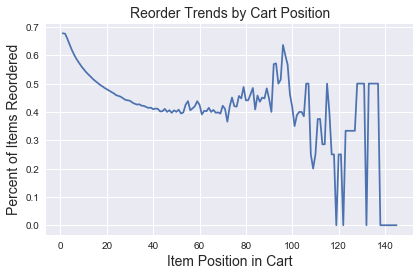

In [141]:
#create data frame to capture percent of reorders by addition of to cart under the reordered column 
df_add_cart_reorder= reorders_.groupby("add_to_cart_order").sum() / reorders_.groupby("add_to_cart_order").count()

#plot reorders in cart position
plt.plot( df_add_cart_reorder.index , df_add_cart_reorder.reordered )
#add labels and title
plt.xlabel("Item Position in Cart", {'fontsize': 14})
plt.ylabel("Percent of Items Reordered", {'fontsize': 14})
plt.title("Reorder Trends by Cart Position", {'fontsize': 14})
#to prevent saving from cutting edges
plt.tight_layout()
#save figure for papers
plt.savefig('cart_position_reorders.png')
#show figure in notebook
plt.show()

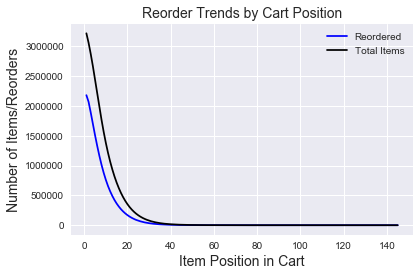

In [140]:
#plot reorders in cart position
plt.plot( reorders_.groupby("add_to_cart_order")['reordered'].sum(), c='b', label="Reordered")
plt.plot( reorders_.groupby("add_to_cart_order")['reordered'].count(), c='k', label= "Total Items")
#add labels and title
plt.xlabel("Item Position in Cart", {'fontsize': 14})
plt.ylabel("Number of Items/Reorders", {'fontsize': 14})
plt.title("Reorder Trends by Cart Position", {'fontsize': 14})
plt.legend(loc=1)
#to prevent saving from cutting edges
plt.tight_layout()
#save figure for papers
plt.savefig('cart_position_values.png')
#show figure in notebook
plt.show()


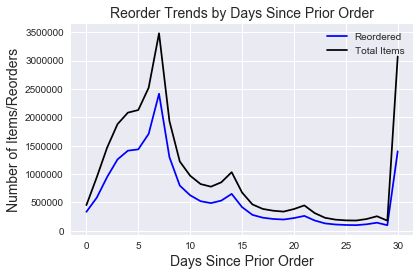

In [139]:
#plot reorders fromdays_since_prior_order
plt.plot( reorders_.groupby("days_since_prior_order")['reordered'].sum(), c= 'blue' , label="Reordered")
plt.plot( reorders_.groupby("days_since_prior_order")['reordered'].count(), c= 'k' , label= "Total Items")
#add labels and title
plt.xlabel("Days Since Prior Order", {'fontsize': 14})
plt.ylabel("Number of Items/Reorders", {'fontsize': 14})
plt.title("Reorder Trends by Days Since Prior Order", {'fontsize': 14})
plt.legend(loc=1)
#to prevent saving from cutting out lables
plt.tight_layout()
#save figure for papers
plt.savefig('dspo_values.png')
#show figure in notebook
plt.show()

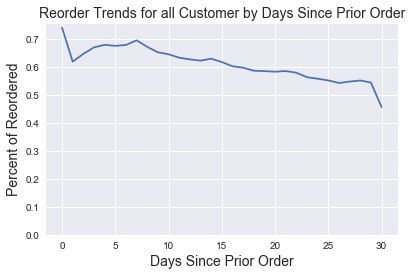

In [129]:
#create data frame to capture percent of reorders per order number under the reordered column 
df_order_number=reorders_.groupby("days_since_prior_order").sum()/reorders_.groupby("days_since_prior_order").count()

#plot reorder by order number (cumulative of all customer with that order number)
plt.plot( df_order_number.index, df_order_number.reordered)
plt.ylim(ymin=0)  # adjust the min leaving max unchanged
#add labels and title
plt.xlabel("Days Since Prior Order", {'fontsize': 14})
plt.ylabel("Percent of Reordered", {'fontsize': 14})

plt.title("Reorder Trends for all Customer by Days Since Prior Order", {'fontsize': 14})
#save figure for papers
plt.tight_layout()
plt.savefig('dspo_reorders_percent.png')
#show figure in notebook
plt.show()